In [ ]:
#Синонимическая близость и алгебраические операции над векторами

In [ ]:
#!pip install nltk==3.7.

In [1]:
# import requests as req
# import re #регулярные выражения
# import pandas as pd
# from datetime import datetime
# from bs4 import BeautifulSoup #парсер

In [21]:
import numpy as np
import pandas as pd
import re
import nltk
#import spacy
import string
import pymorphy2

In [9]:
##Чтение датасета с текстом
# df = pd.read_csv("vtomske_COV_2021.csv", encoding='UTF8', sep=",")
df = pd.read_csv("reviews.csv", encoding='UTF8', sep="\t")
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [31]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('russian'))
# функция, удаляющая стопслова из текстов
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Удаление эмодзи
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
#Удаление URL
# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
from bs4 import BeautifulSoup
#Function for removing html
def html(text):
    return BeautifulSoup(text, "lxml").text
#Можно выполнить при помощи NLTK. Заодно проведем лемматизацию
import pymorphy3
from pymorphy3 import MorphAnalyzer
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
morph=pymorphy3.MorphAnalyzer()

def tokenize_lemmas(sent, pat=r"(?u)\b\w\w+\b"): 
    return [morph.parse(tok)[0].normal_form 
            for tok in regexp_tokenize(sent, pat)]


In [33]:
df['text_ready']  = df['review'].str.lower()
df['text_ready'] = df['text_ready'].str.replace('\d+', '') 
df['text_ready'] = df['text_ready'].str.replace('[^\w\s]','')
df["text_ready"] = df["text_ready"].apply(stopwords)
df['text_ready'] = df['text_ready'].apply(emoji)
df['text_ready'] = df['text_ready'].apply(remove_urls)
df['text_ready'] = df['text_ready'].apply(html)
df["text_ready"] = df["text_ready"].map(lambda x: " ".join(tokenize_lemmas(x)))
df[['text_ready']].head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\w'
C:\Users\User\AppData\Local\Temp\ipykernel_1324\1887650095.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['text_ready'] = df['text_ready'].str.replace('\d+', '')
C:\Users\User\AppData\Local\Temp\ipykernel_1324\1887650095.py:3: SyntaxWarning: invalid escape sequence '\w'
  df['text_ready'] = df['text_ready'].str.replace('[^\w\s]','')
C:\Users\User\AppData\Local\Temp\ipykernel_1324\1289156741.py:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "lxml").text


,text_ready
0,качество плохой пошив ужасный горловина напере...
1,товар отдать другой человек получить посылка л...
2,ужасный синтетик тонкий общий представить карт...
3,товар прийти продавец продлить защита мой согл...
4,кофточка голый синтетик носить возможно


In [35]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [37]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=5,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)
#vector_size — размер векторного представления слова (word embedding).
#negative — сколько неконтекстных слов учитывать в обучении, используя negative sampling.
#alpha — начальный learning_rate, используемый в алгоритме обратного распространения ошибки (Backpropogation).
#min_alpha — минимальное значение learning_rate, на которое может опуститься в процессе обучения.
#sg — если 1, то используется реализация Skip-gram; если 0, то CBOW.

In [39]:
#Получаем лист слов
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess

class MySentences(object):
    def __init__(self, docs):
        self.corpus = docs
    def __iter__(self):
        for doc in self.corpus:
            doc_sentences = sent_tokenize(doc)
            for sent in doc_sentences:
                yield simple_preprocess(sent) # yields a tokenized 

In [41]:
sentences = MySentences(df['text_ready'].tolist())

In [47]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [49]:
#Получаем словарь
w2v_model.build_vocab(sentences)

In [51]:
#Обучение
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=6, report_delay=1)

(2634202, 7477128)

In [53]:
#для сохранения оперативной памяти можно написать следующее
w2v_model.init_sims(replace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_1324\232342886.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [55]:
w2v_model.wv.most_similar(positive=["отлично"], topn=30)

[('идеально', 0.9790433049201965),
 ('прекрасно', 0.9716802835464478),
 ('великолепно', 0.9530889391899109),
 ('село', 0.9475043416023254),
 ('хорошо', 0.9440132975578308),
 ('русый', 0.9438509345054626),
 ('росс', 0.9418482184410095),
 ('подойти', 0.9403215646743774),
 ('юбочка', 0.9385396242141724),
 ('влить', 0.9358856678009033),
 ('замечательный', 0.9342427253723145),
 ('от', 0.9305651783943176),
 ('шикарно', 0.9282066822052002),
 ('сель', 0.9281673431396484),
 ('идеальный', 0.9279220700263977),
 ('российский', 0.9275109171867371),
 ('сесть', 0.9254463911056519),
 ('комбез', 0.9221795797348022),
 ('расти', 0.9203385710716248),
 ('об', 0.9197101593017578),
 ('русский', 0.919147253036499),
 ('хорошенький', 0.9186542630195618),
 ('ооооочень', 0.9184327125549316),
 ('штанишки', 0.9179267883300781),
 ('хорошоя', 0.9177348613739014),
 ('круто', 0.9171121120452881),
 ('клёвый', 0.9159724712371826),
 ('чётко', 0.9127278327941895),
 ('оочень', 0.9126552939414978),
 ('пижамка', 0.91204881668

In [57]:
w2v_model.wv.most_similar(positive=["товар", "продукт", "покупка"], topn=50)

[('удовлетворить', 0.9423552751541138),
 ('редко', 0.9312286972999573),
 ('крайне', 0.9261736869812012),
 ('продукция', 0.9256877303123474),
 ('продовца', 0.9250606298446655),
 ('лохотрон', 0.9246988892555237),
 ('благодарить', 0.9244413375854492),
 ('ответственный', 0.9209704399108887),
 ('встречать', 0.920798659324646),
 ('отзывчивый', 0.9199292659759521),
 ('респект', 0.9199272990226746),
 ('приобретать', 0.9196794033050537),
 ('добросовестный', 0.9190525412559509),
 ('данный', 0.9189517498016357),
 ('недовольный', 0.9180803298950195),
 ('разочарованный', 0.9151296615600586),
 ('совесть', 0.9141904711723328),
 ('честный', 0.9141334295272827),
 ('тавар', 0.9138588905334473),
 ('акция', 0.9138174057006836),
 ('хоть', 0.9138056039810181),
 ('обслуживание', 0.9137479066848755),
 ('пришол', 0.9116727113723755),
 ('надёжный', 0.9113488793373108),
 ('процветание', 0.9090681076049805),
 ('находка', 0.9085511565208435),
 ('умница', 0.9059590101242065),
 ('переплатить', 0.9053380489349365),
 

In [59]:
#Векторы можно складывать и вычитать. Например, рассмотрим такой вариант: “товар” + “продавец” — “ужасный”:
w2v_model.wv.most_similar(positive=["товар", "продавец"], negative=["плохой"], topn=1000)

[('уверять', 0.7975152134895325),
 ('письмо', 0.7966079711914062),
 ('посылка', 0.7863695025444031),
 ('утверждать', 0.7818073630332947),
 ('якобы', 0.7791005373001099),
 ('смс', 0.7786842584609985),
 ('оперативно', 0.7762668132781982),
 ('адрес', 0.7740581035614014),
 ('сообщить', 0.7725223302841187),
 ('ссылаться', 0.7654159665107727),
 ('ответ', 0.759249746799469),
 ('сообщение', 0.7579487562179565),
 ('поставщик', 0.7557063102722168),
 ('повторно', 0.7555871605873108),
 ('вежливый', 0.7553340792655945),
 ('игнорировать', 0.7546858787536621),
 ('тишина', 0.7538144588470459),
 ('поступить', 0.753026008605957),
 ('отслеживание', 0.7519553899765015),
 ('заверить', 0.7502436637878418),
 ('повторный', 0.7466971278190613),
 ('предупредить', 0.7466148138046265),
 ('отслеживать', 0.7459707260131836),
 ('присвоить', 0.7448712587356567),
 ('заказ', 0.744572103023529),
 ('уведомление', 0.7433081865310669),
 ('продовца', 0.7422237396240234),
 ('убеждать', 0.7414737343788147),
 ('запрос', 0.7410

In [63]:
#определить наиболее близкое слово из списка к данному слово
w2v_model.wv.most_similar_to_given("хороший", ["товар", "продавец", "человек", "куртка"])

'куртка'

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction 
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    vectors_words = [model.wv.word_vec(word)]
    word_labels = [word]
    color_list = ['red']

    close_words = model.wv.most_similar(word)
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__(wrd_score[0]) #word_vec
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__(wrd) #word_vec
        vectors_words.append(wrd_vector)
        word_labels.append(wrd)
        color_list.append('green')

    vectors_words = PCA(n_components=13).fit_transform(vectors_words, )

    # t-SNE reduction
    Y = TSNE(n_components=2, random_state=0, perplexity=12, init="pca").fit_transform(vectors_words) #init="pca"
        #.fit_transform(vectors_words)
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                    "y": [y for y in Y[:, 1]],
                    "words": word_labels,
                    "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

C:\Users\User\AppData\Local\Temp\ipykernel_1324\319534167.py:11: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  vectors_words = [model.wv.word_vec(word)]


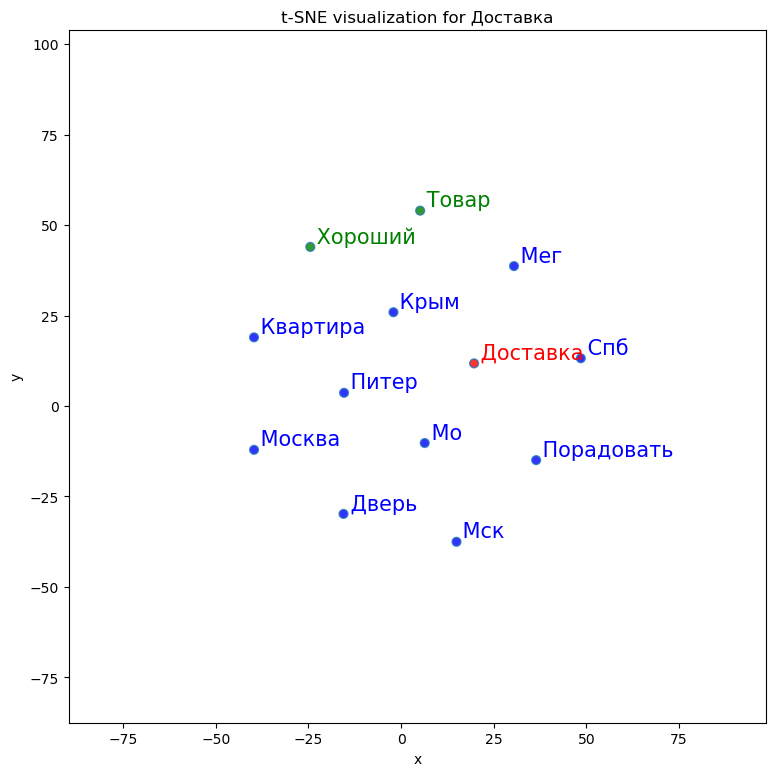

In [153]:
tsne_scatterplot(w2v_model, "доставка",  ["товар", "хороший"])

,text_ready
0,качество плохой пошив ужасный горловина напере...
1,товар отдать другой человек получить посылка л...
2,ужасный синтетик тонкий общий представить карт...
3,товар прийти продавец продлить защита мой согл...
4,кофточка голый синтетик носить возможно
...,...
89995,сделать достаточно ткань сделать рисунок замет...
89996,накидка шикарный спасибо большой провдо линять...
89997,спасибо большой продовца рекомендовать заказат...
89998,очень довольный заказ маленький месяц рб курье...
